## Check for CUDA

In [3]:
!nvidia-smi

Sat Nov 30 17:55:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0              N/A /  60W |      7MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.io import read_image
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm
import dlib
import cv2
import os
from IPython import embed

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Detect Faces using dlib

In [64]:
def convert_and_trim_bb(image, rect):
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()
    
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
    
	w = endX - startX
	h = endY - startY
	return (startX, startY, w, h)

def get_frames(input_path,output_path,file_name):
    cap = cv2.VideoCapture(input_path)
    frame_id = 0
    frame_skip = 60
    frame_count = 0
    cropped = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id > frame_skip - 1:
            frame_count += 1
            boxes = get_face_landmarks(frame)
            if len(boxes) > 0:
                try:
                    cropped = get_cropped_image(frame, boxes)
                except:
                    continue
            output_file =  file_name +'_'+ str(frame_count) +'.jpg'
            if cropped is not None:
                try:
                    cv2.imwrite(os.path.join(output_path, output_file), cropped)
                except:
                    continue
            frame_id = 0
            print(input_path + '/' + output_file)
            continue
        frame_id += 1
        
    cap.release()
    cv2.destroyAllWindows()

def get_face_landmarks(image):
    detector = dlib.get_frontal_face_detector()
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rects = detector(rgb)
    boxes = [convert_and_trim_bb(image, r) for r in rects]
    return boxes

def get_cropped_image(image, boxes):
    height,  width = image.shape[0], image.shape[1]
    scale_factor = 1.5
    for (x, y, w, h) in boxes:
        new_h = h * scale_factor
        new_w = w * scale_factor
        delta_h = (new_h - h) / 2
        delta_w = (new_w - w) / 2
        new_y = abs(y - delta_h)
        new_x = abs(x - delta_w)
        cropped = image[int(new_y):int(new_y+new_h), int(new_x):int(new_x+new_w)]
    return cropped

dataset_directory = "./Celeb-DF-v2/"

(images, directories, id) = ([], {}, 0)

for (subdirs, dirs, files) in os.walk(dataset_directory):
    print(subdirs)
    for subdir in dirs:
        directories[id] = subdir
        subjectpath = os.path.join(dataset_directory, subdir)
        output_path = subjectpath + '/' + subdir+ '_images'
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        for filename in os.listdir(subjectpath):
            if filename.endswith('.mp4'):
                input_path = subjectpath + '/' + filename
                file_name = filename.split('.')[0]
                get_frames(input_path,output_path,file_name)
        id += 1

./Celeb-DF-v2/
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_1.jpg
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_2.jpg
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_3.jpg
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_4.jpg
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_5.jpg
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_6.jpg
./Celeb-DF-v2/Celeb-real/id2_0000.mp4/id2_0000_7.jpg
./Celeb-DF-v2/Celeb-real/id6_0001.mp4/id6_0001_1.jpg
./Celeb-DF-v2/Celeb-real/id6_0001.mp4/id6_0001_2.jpg
./Celeb-DF-v2/Celeb-real/id6_0001.mp4/id6_0001_3.jpg
./Celeb-DF-v2/Celeb-real/id6_0001.mp4/id6_0001_4.jpg
./Celeb-DF-v2/Celeb-real/id6_0001.mp4/id6_0001_5.jpg
./Celeb-DF-v2/Celeb-real/id7_0000.mp4/id7_0000_1.jpg
./Celeb-DF-v2/Celeb-real/id7_0000.mp4/id7_0000_2.jpg
./Celeb-DF-v2/Celeb-real/id7_0000.mp4/id7_0000_3.jpg
./Celeb-DF-v2/Celeb-real/id7_0000.mp4/id7_0000_4.jpg
./Celeb-DF-v2/Celeb-real/id2_0002.mp4/id2_0002_1.jpg
./Celeb-DF-v2/Celeb-real/id2_0002.mp4/id2_0002_2.jpg
./Celeb-DF-v2/Celeb-real/id2_00

## XceptionNet + Celeb-DF-v2 Training Part

In [ ]:
class dataset_customizer(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = '/home/utku/AI-Powered-Deepfake-Detection/Celeb-DF-v2_images/'
        self.transform = transform
        file_list = glob.glob(os.path.join(self.imgs_path, "*"))  # Get directories
        self.data = []
        self.class_map = {"Celeb-real_images": 0, "Celeb-synthesis_images": 1}

        for class_path in file_list:
            class_name = os.path.basename(class_path)  # Cross-platform folder name
            if class_name not in self.class_map:
                print(f"Invalid class: {class_name}")
                print(f"Available classes: {self.class_map.keys()}")
                raise KeyError(f"Class mapping not found: {class_name}")

            for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
                self.data.append([img_path, class_name])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = read_image(img_path)

        # Add error handling
        try:
            class_id = self.class_map[class_name]
        except KeyError:
            print(f"Invalid class: {class_name}")
            print(f"Available classes: {self.class_map.keys()}")
            raise

        class_id = torch.tensor([class_id])

        if self.transform:
            img = self.transform(img)

        return img, class_id

## Train and Val set transformation

In [5]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor()
    ])

print(train_transforms)

Compose(
    ToPILImage()
    Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
dataset = dataset_customizer(transform=train_transforms)
train_size = int(0.8 * len(dataset))
print("Train size " + str((train_size)))
val_size = len(dataset) - train_size
print("Val size " + str((val_size)))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])	
print("Dataset size " + str(len(dataset)))

Train size 3032
Val size 758
Dataset size 3790


In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
print(len(train_data_loader))
print(len(val_data_loader))

190
48


## Initialize XceptionNet model

In [8]:
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
criterion = nn.BCEWithLogitsLoss()
print(model)

/home/utku/.local/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

## Training

In [9]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(100):
    print("=================")
    print(f"Epoch: {epoch+1}")

    model.train()
    avg_loss_train = 0
    correct = 0
    total = 0
        
    for i, data in enumerate(train_data_loader, 0):
    
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs.float())
        outputs = torch.sigmoid(outputs) 
    
        optimizer.zero_grad()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        avg_loss_train += loss.item()
        predicted = (outputs > 0.5).float()  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_loss = avg_loss_train / len(train_data_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Train Loss: {epoch_loss} | Train Accuracy: {epoch_acc}")    

    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_data_loader:
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            outputs = torch.sigmoid(outputs)  
        
            optimizer.zero_grad()
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()
            
            predicted = (outputs > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / len(val_data_loader)
        epoch_acc = correct / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f"Val Loss: {epoch_loss} | Val Accuracy: {epoch_acc}")

Epoch: 1
Train Loss: 0.4930789029911945 | Train Accuracy: 0.850263852242744
Val Loss: 0.43404437229037285 | Val Accuracy: 0.91688654353562
Epoch: 2
Train Loss: 0.42850611131442223 | Train Accuracy: 0.9228232189973615
Val Loss: 0.4318071051190297 | Val Accuracy: 0.9195250659630607
Epoch: 3
Train Loss: 0.42209170037194305 | Train Accuracy: 0.9386543535620053
Val Loss: 0.4361800340314706 | Val Accuracy: 0.9195250659630607
Epoch: 4
Train Loss: 0.4167657334553568 | Train Accuracy: 0.9475593667546174
Val Loss: 0.424104747051994 | Val Accuracy: 0.9300791556728232
Epoch: 5
Train Loss: 0.41737116983062345 | Train Accuracy: 0.9478891820580475
Val Loss: 0.4159608023862044 | Val Accuracy: 0.9630606860158312
Epoch: 6
Train Loss: 0.41278951732735886 | Train Accuracy: 0.9528364116094987
Val Loss: 0.45416840352118015 | Val Accuracy: 0.8403693931398417
Epoch: 7
Train Loss: 0.4167598627115551 | Train Accuracy: 0.9462401055408971
Val Loss: 0.4147637976954381 | Val Accuracy: 0.9538258575197889
Epoch: 8
Tr

## Alternative
## Training and Plot Feature Extraction Layers (First 10 layers of XceptionNet)

In [ ]:
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

# Training and validation metrics
train_losses, train_accs, val_losses, val_accs = [], [], [], []

# Let's track only the first few layers to save the feature maps
layer_outputs = []  # The layer outputs we want to store

# Hook function: To get the layer outputs
def hook_fn(module, input, output):
    # We save the layer output only once
    if len(layer_outputs) < 10:  # We are saving the first 10 layers
        layer_outputs.append(output.detach().cpu().numpy())  # We only save the feature map

# Let's track only specific layers (the first 10 Conv2d layers)
hooks = []
count = 0
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)
        count += 1
    if count == 10:  # We stop tracking the first 10 layers
        break

for epoch in range(1):
    print("=================")
    print(f"Epoch: {epoch+1}")
    
    model.train()
    avg_loss_train = 0
    correct = 0
    total = 0

    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs.float())
        outputs = torch.sigmoid(outputs)

        optimizer.zero_grad()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        avg_loss_train += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = avg_loss_train / len(train_data_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Train Loss: {epoch_loss} | Train Accuracy: {epoch_acc}")

    # Validation phase
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(val_data_loader)
        epoch_acc = correct / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f"Val Loss: {epoch_loss} | Val Accuracy: {epoch_acc}")
    print("=================")

    print(layer_outputs)
    # Let's save it only once (in the first epoch)
    if epoch == 0:
        fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # We place the 10 layers in 2 rows side by side
        axes = axes.flatten()  # We flatten the 2x5 grid
        for i, output in enumerate(layer_outputs):  # We track the first 10 layers
            print(f"Layer {i+1} output shape: {output.shape}")
            axes[i].imshow(output[0, 0], cmap='gray')  # Plotting the first channel
            axes[i].set_title(f"Layer {i+1} Feature Map ")
            axes[i].axis('off')  # We turn off the axes
        plt.colorbar(axes[0].images[0], ax=axes, orientation='horizontal')
        plt.savefig(f"layers_1_to_10_feature_map_epoch.png")
        plt.close()


/home/utku/.local/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch: 1
Train Loss: 0.4969620334474664 | Train Accuracy: 0.8308047493403694
Val Loss: 0.44889280820886296 | Val Accuracy: 0.91688654353562
[array([[[[-1.03403069e-01, -1.06455751e-01, -1.10157095e-01, ...,
          -4.88076955e-02, -1.11572752e-02, -5.22409640e-02],
         [-1.03403069e-01, -1.06455751e-01, -1.10157095e-01, ...,
          -7.36662373e-02, -2.79152244e-02, -4.50774990e-02],
         [-1.03403069e-01, -1.10158555e-01, -1.10157095e-01, ...,
          -1.03995383e-01, -2.86558419e-02, -5.62014543e-02],
         ...,
         [-7.21675009e-02, -5.48164696e-02, -4.81994301e-02, ...,
          -4.08117147e-03, -6.42316462e-03, -9.73454211e-04],
         [-7.07306415e-02, -6.65867105e-02, -5.93430474e-02, ...,
          -6.02919050e-02, -7.01202899e-02, -7.43896514e-02],
         [-6.55354038e-02, -6.23642169e-02, -6.16313219e-02, ...,
          -8.24217349e-02, -8.88943523e-02, -9.04446095e-02]],

        [[ 3.88002753e-01,  3.84716839e-01,  3.81157517e-01, ...,
         

## Plotting Loss / Accuracy vs. Epochs curves

Plot successfully saved at: ./training_curves_celebdf_100epoch


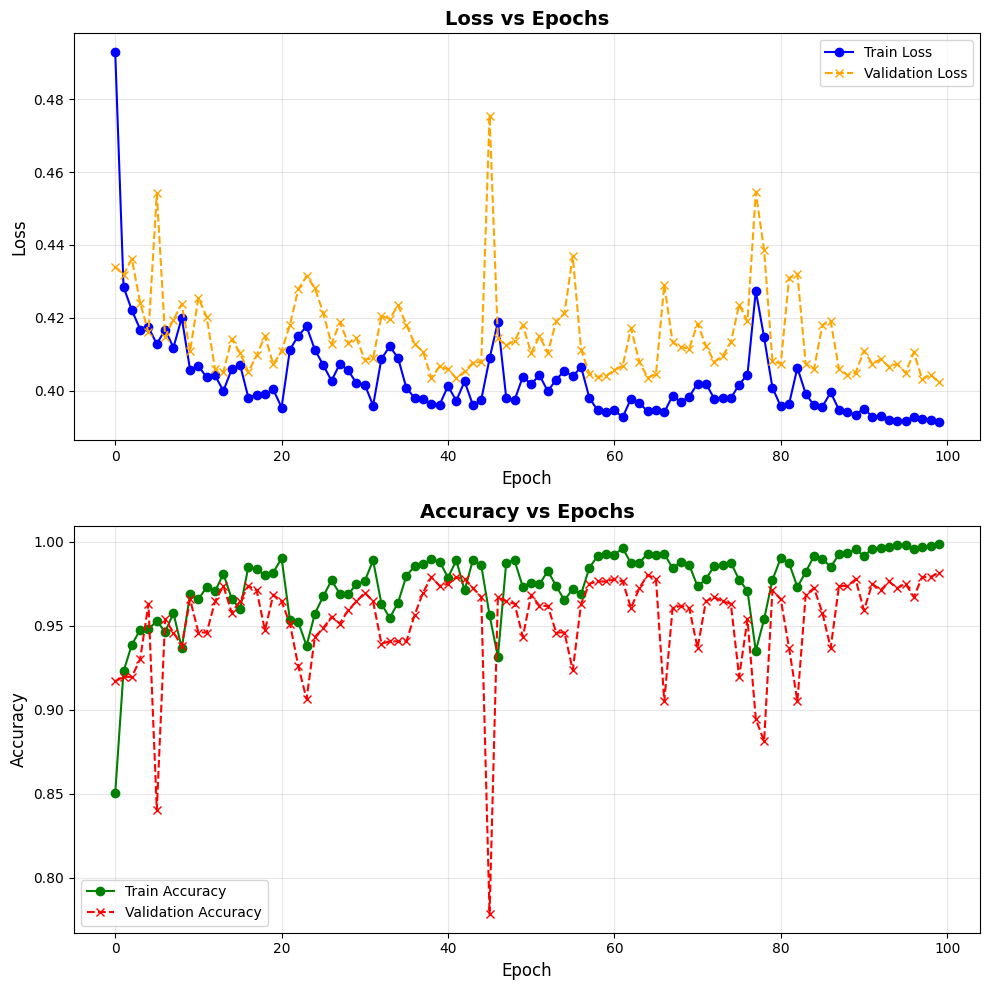

In [10]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Function to plot and save training and validation loss and accuracy curves.

    Args:
        train_losses (list): Training losses.
        train_accuracies (list): Training accuracies.
        val_losses (list): Validation losses.
        val_accuracies (list): Validation accuracies.
        save_path (str): File path to save the plot. Default is 'training_curves.png'.
    """
    save_path = './training_curves_celebdf_100epoch'
    # Set the figure size and layout
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=100)

    # Plot training and validation losses
    ax1.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    ax1.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', marker='x')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss vs Epochs', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    # Plot training and validation accuracies
    ax2.plot(train_accuracies, label='Train Accuracy', color='green', linestyle='-', marker='o')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='--', marker='x')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy vs Epochs', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)

    # Adjust spacing between plots
    plt.tight_layout()

    # Save the plot to the specified file path
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot successfully saved at: {save_path}")

    # Display the plot
    plt.show()


plot_curves(train_losses, train_accs, val_losses, val_accs)


In [11]:
torch.save({
            'model': model,
            'model_state_dict': model.state_dict(),
            'train_losses' : train_losses,
            'train_accs' : train_accs,
            'val_losses' : val_losses,
            'val_accs' : val_accs,
            }, 'CelebDF_100epochs.pt')
print('Trained model is saved')

Trained model is saved


In [12]:
print("Training Losses:")
print(train_losses)
print("Training Accuracies:")
print(train_accs)
print("Validation Losses:")
print(val_losses)
print("Validation Accuracies:")
print(val_accs)

Training Losses:
[0.4930789029911945, 0.42850611131442223, 0.42209170037194305, 0.4167657334553568, 0.41737116983062345, 0.41278951732735886, 0.4167598627115551, 0.41182023475044655, 0.41997981996912703, 0.40570392561586277, 0.4067480954684709, 0.40361250968355883, 0.4041523219723451, 0.39990410726321374, 0.4058142850273534, 0.4071352005004883, 0.3980773301501023, 0.3988432294444034, 0.39900821635597633, 0.4002802781368557, 0.3953306340857556, 0.41120649795783193, 0.4150588189300738, 0.4176074969141107, 0.41122687521733736, 0.4070148602912301, 0.40268817810635815, 0.4073025869695764, 0.4055872317991759, 0.4019674288599115, 0.4016309335043556, 0.3958597642810721, 0.40872293428370826, 0.4121193962661844, 0.40895066198549773, 0.4006491742636028, 0.39796871825268393, 0.3976236878257049, 0.396235497060575, 0.3961255989576641, 0.40120296760609275, 0.3971979534939716, 0.40252981844701263, 0.39594854869340596, 0.3974641740322113, 0.40880710012034366, 0.41883303538749095, 0.39800517841389305, 0

## XceptionNet + FaceForensics++ Training Part

In [13]:
class dataset_customizer(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = '/home/utku/AI-Powered-Deepfake-Detection/FaceForensics_images/'
        self.transform = transform
        file_list = glob.glob(os.path.join(self.imgs_path, "*"))  # Get directories
        self.data = []
        self.class_map = {"Real": 0, "Fake": 1}

        for class_path in file_list:
            class_name = os.path.basename(class_path)  # Cross-platform folder name
            if class_name not in self.class_map:
                print(f"Invalid class: {class_name}")
                print(f"Available classes: {self.class_map.keys()}")
                raise KeyError(f"Class mapping not found: {class_name}")

            for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
                self.data.append([img_path, class_name])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = read_image(img_path)

        # Add error handling
        try:
            class_id = self.class_map[class_name]
        except KeyError:
            print(f"Invalid class: {class_name}")
            print(f"Available classes: {self.class_map.keys()}")
            raise

        class_id = torch.tensor([class_id])

        if self.transform:
            img = self.transform(img)

        return img, class_id


## Train and Val set transformation

In [14]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    ])

dataset = dataset_customizer(transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])	

len(dataset)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
len(train_data_loader)


255

## Initialize XceptionNet model

In [15]:
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
criterion = nn.BCEWithLogitsLoss()

/home/utku/.local/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

## Training

In [16]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(100):
    print("=================")
    print(f"Epoch: {epoch+1}")

    model.train()
    avg_loss_train = 0
    correct = 0
    total = 0
  
    for i, data in enumerate(train_data_loader, 0):
    
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs.float())
        outputs = torch.sigmoid(outputs)
    
        optimizer.zero_grad()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        avg_loss_train += loss.item()
        predicted = (outputs > 0.5).float() 
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_loss = avg_loss_train / len(train_data_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Train Loss: {epoch_loss} | Train Accuracy: {epoch_acc}")    

    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_data_loader:
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            outputs = torch.sigmoid(outputs) 
        
            optimizer.zero_grad()
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()
            
            predicted = (outputs > 0.5).float() 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / len(val_data_loader)
        epoch_acc = correct / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f"Val Loss: {epoch_loss} | Val Accuracy: {epoch_acc}")

Epoch: 1
Train Loss: 0.5060590222770093 | Train Accuracy: 0.8097225632212128
Val Loss: 0.4802841008640826 | Val Accuracy: 0.830225711481845
Epoch: 2
Train Loss: 0.4749586801902921 | Train Accuracy: 0.8318192978148785
Val Loss: 0.47708679269999266 | Val Accuracy: 0.8243375858684985
Epoch: 3
Train Loss: 0.4626831436858458 | Train Accuracy: 0.8494966854898109
Val Loss: 0.47010247875005007 | Val Accuracy: 0.830225711481845
Epoch: 4
Train Loss: 0.45875529226134804 | Train Accuracy: 0.8470414927571814
Val Loss: 0.466906510759145 | Val Accuracy: 0.8292443572129539
Epoch: 5
Train Loss: 0.44744706387613337 | Train Accuracy: 0.8718389393567395
Val Loss: 0.4703980013728142 | Val Accuracy: 0.7968596663395485
Epoch: 6
Train Loss: 0.4404871232369367 | Train Accuracy: 0.8860790572059907
Val Loss: 0.4602829357609153 | Val Accuracy: 0.8488714425907753
Epoch: 7
Train Loss: 0.43755138937164756 | Train Accuracy: 0.8927080775840903
Val Loss: 0.4629274420440197 | Val Accuracy: 0.81648675171737
Epoch: 8
Trai

## Plotting Loss / Accuracy vs. Epochs curves

Plot successfully saved at: ./training_curves_ff_100epoch


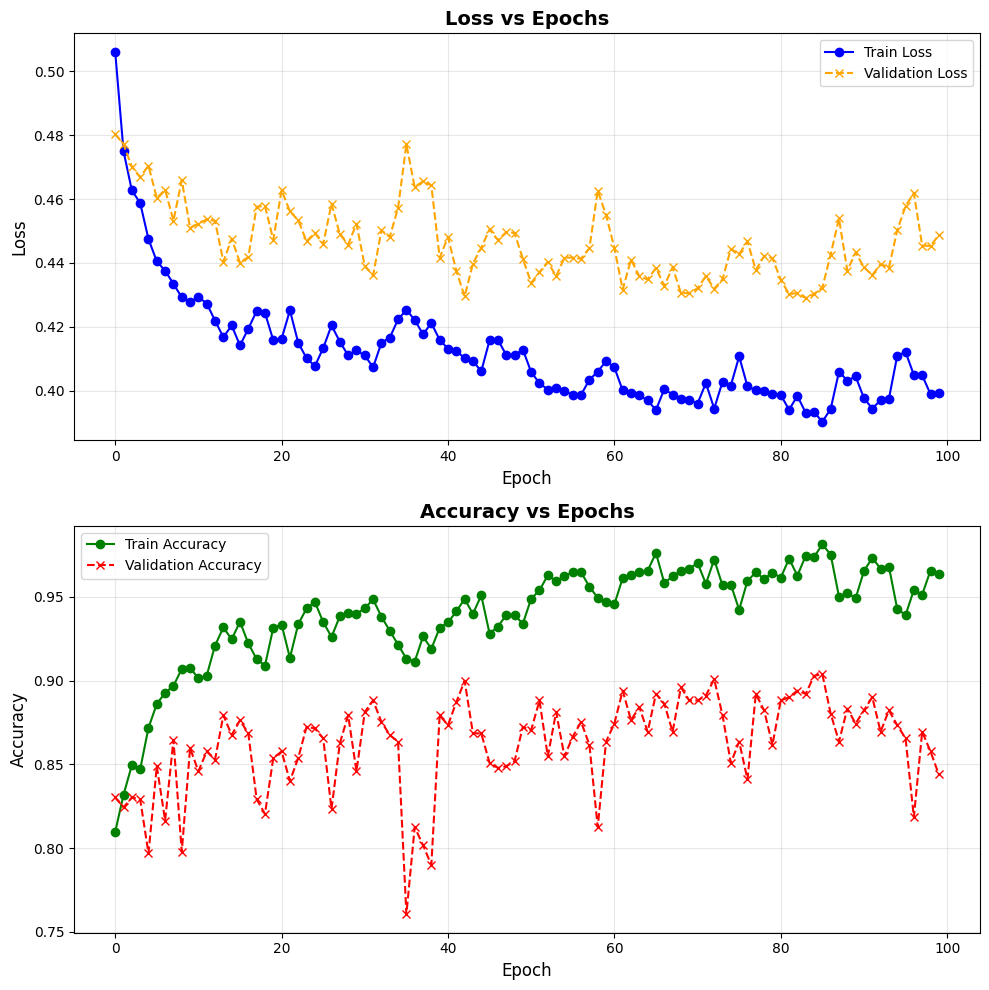

In [17]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Function to plot and save training and validation loss and accuracy curves.

    Args:
        train_losses (list): Training losses.
        train_accuracies (list): Training accuracies.
        val_losses (list): Validation losses.
        val_accuracies (list): Validation accuracies.
        save_path (str): File path to save the plot. Default is 'training_curves.png'.
    """
    save_path = './training_curves_ff_100epoch'
    # Set the figure size and layout
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=100)

    # Plot training and validation losses
    ax1.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    ax1.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', marker='x')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss vs Epochs', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    # Plot training and validation accuracies
    ax2.plot(train_accuracies, label='Train Accuracy', color='green', linestyle='-', marker='o')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='--', marker='x')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy vs Epochs', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)

    # Adjust spacing between plots
    plt.tight_layout()

    # Save the plot to the specified file path
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot successfully saved at: {save_path}")

    # Display the plot
    plt.show()


plot_curves(train_losses, train_accs, val_losses, val_accs)


In [18]:
torch.save({
            'model': model,
            'model_state_dict': model.state_dict(),
            'train_losses' : train_losses,
            'train_accs' : train_accs,
            'val_losses' : val_losses,
            'val_accs' : val_accs,
            }, 'FF_100epochs.pt')
print('Trained model is saved')

Trained model is saved


In [19]:
print("Training Losses:")
print(train_losses)
print("Training Accuracies:")
print(train_accs)
print("Validation Losses:")
print(val_losses)
print("Validation Accuracies:")
print(val_accs)

Training Losses:
[0.5060590222770093, 0.4749586801902921, 0.4626831436858458, 0.45875529226134804, 0.44744706387613337, 0.4404871232369367, 0.43755138937164756, 0.4334703159098532, 0.42920623643725525, 0.4278218967073104, 0.4293366266231911, 0.4273009356330423, 0.42194927101041757, 0.41675862740067876, 0.4204281306734272, 0.4141722481624753, 0.41941418145217146, 0.4249291749561534, 0.4243829574070725, 0.41580495986283994, 0.4162728112117917, 0.4251659291632035, 0.4149946142645443, 0.41020051731782803, 0.40770991152408076, 0.41332858193154426, 0.42044399778048197, 0.41536471446355183, 0.4110584327987596, 0.4126051397884593, 0.4110452763005799, 0.40732270607761306, 0.41501411164508145, 0.416597357450747, 0.42231602914193095, 0.425303805809395, 0.4221918932363099, 0.417660820016674, 0.4211653663831599, 0.4159329180623971, 0.41314234675145617, 0.41249867490693637, 0.4101770923418157, 0.4093146008603713, 0.4060889412375057, 0.4158000271694333, 0.4159418207757613, 0.411195214472565, 0.411064

## XceptionNet + Celeb-DF-v2 + FaceForensics++ Hybrid Approach Training Part

In [5]:
class dataset_customizer(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = '/home/utku/AI-Powered-Deepfake-Detection/Hybrid_images/'
        self.transform = transform
        file_list = glob.glob(os.path.join(self.imgs_path, "*"))  # Get directories
        self.data = []
        self.class_map = {"Real": 0, "Fake": 1}

        for class_path in file_list:
            class_name = os.path.basename(class_path)  # Cross-platform folder name
            if class_name not in self.class_map:
                print(f"Invalid class: {class_name}")
                print(f"Available classes: {self.class_map.keys()}")
                raise KeyError(f"Class mapping not found: {class_name}")

            for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
                self.data.append([img_path, class_name])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = read_image(img_path)

        # Add error handling
        try:
            class_id = self.class_map[class_name]
        except KeyError:
            print(f"Invalid class: {class_name}")
            print(f"Available classes: {self.class_map.keys()}")
            raise

        class_id = torch.tensor([class_id])

        if self.transform:
            img = self.transform(img)

        return img, class_id

## Train and Val set transformation

In [6]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor()
    ])

print(train_transforms)

Compose(
    ToPILImage()
    Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
dataset = dataset_customizer(transform=train_transforms)
train_size = int(0.8 * len(dataset))
print("Train size " + str((train_size)))
val_size = len(dataset) - train_size
print("Val size " + str((val_size)))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])	
print("Dataset size " + str(len(dataset)))

Train size 7105
Val size 1777
Dataset size 8882


In [8]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
print(len(train_data_loader))
print(len(val_data_loader))

445
112


## Initialize XceptionNet model

In [9]:
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
criterion = nn.BCEWithLogitsLoss()
print(model)

/home/utku/.local/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

## Training

In [10]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(100):
    print("=================")
    print(f"Epoch: {epoch+1}")

    model.train()
    avg_loss_train = 0
    correct = 0
    total = 0
        
    for i, data in enumerate(train_data_loader, 0):
    
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs.float())
        outputs = torch.sigmoid(outputs) 
    
        optimizer.zero_grad()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        avg_loss_train += loss.item()
        predicted = (outputs > 0.5).float()  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_loss = avg_loss_train / len(train_data_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Train Loss: {epoch_loss} | Train Accuracy: {epoch_acc}")    

    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_data_loader:
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            outputs = torch.sigmoid(outputs)  
        
            optimizer.zero_grad()
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()
            
            predicted = (outputs > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / len(val_data_loader)
        epoch_acc = correct / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f"Val Loss: {epoch_loss} | Val Accuracy: {epoch_acc}")

Epoch: 1
Train Loss: 0.5031558181462663 | Train Accuracy: 0.813652357494722
Val Loss: 0.48442314911101547 | Val Accuracy: 0.7687113111986494
Epoch: 2
Train Loss: 0.4655273473664616 | Train Accuracy: 0.8544686840253343
Val Loss: 0.4842482685510601 | Val Accuracy: 0.7540799099606078
Epoch: 3
Train Loss: 0.45101386737287713 | Train Accuracy: 0.8741731175228712
Val Loss: 0.4537743090518883 | Val Accuracy: 0.8660664040517726
Epoch: 4
Train Loss: 0.45285126767801437 | Train Accuracy: 0.8707952146375791
Val Loss: 0.45856521651148796 | Val Accuracy: 0.859313449634215
Epoch: 5
Train Loss: 0.4425237537769789 | Train Accuracy: 0.8874032371569317
Val Loss: 0.45666681150240557 | Val Accuracy: 0.8452447945976365
Epoch: 6
Train Loss: 0.4338634438729018 | Train Accuracy: 0.9061224489795918
Val Loss: 0.4444776579205479 | Val Accuracy: 0.8840742824985931
Epoch: 7
Train Loss: 0.4397843085647969 | Train Accuracy: 0.8990851513019
Val Loss: 0.4497669198151146 | Val Accuracy: 0.8716938660664041
Epoch: 8
Trai

## Plotting Loss / Accuracy vs. Epochs curves

Plot successfully saved at: ./training_curves_hybrid_100epoch


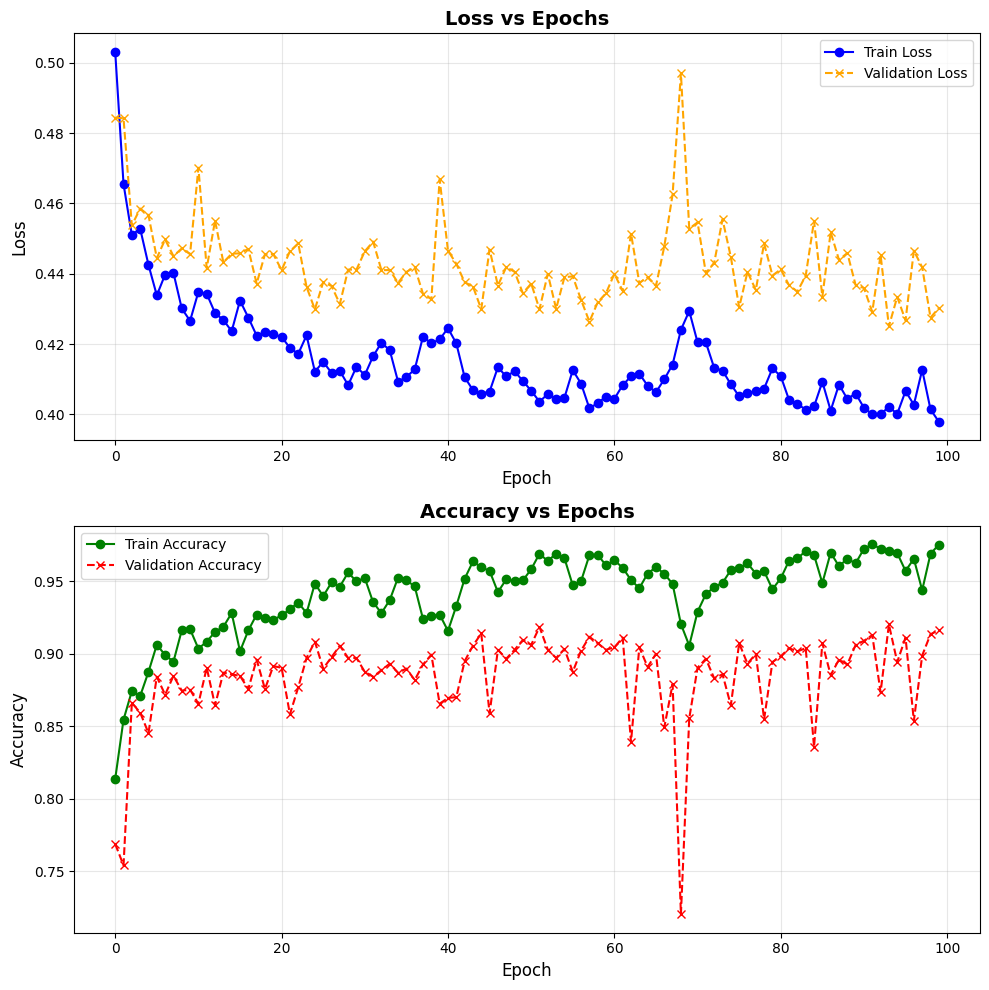

In [14]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Function to plot and save training and validation loss and accuracy curves.

    Args:
        train_losses (list): Training losses.
        train_accuracies (list): Training accuracies.
        val_losses (list): Validation losses.
        val_accuracies (list): Validation accuracies.
        save_path (str): File path to save the plot. Default is 'training_curves.png'.
    """
    save_path = './training_curves_hybrid_100epoch'
    # Set the figure size and layout
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=100)

    # Plot training and validation losses
    ax1.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    ax1.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', marker='x')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss vs Epochs', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    # Plot training and validation accuracies
    ax2.plot(train_accuracies, label='Train Accuracy', color='green', linestyle='-', marker='o')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='--', marker='x')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy vs Epochs', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)

    # Adjust spacing between plots
    plt.tight_layout()

    # Save the plot to the specified file path
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot successfully saved at: {save_path}")

    # Display the plot
    plt.show()


plot_curves(train_losses, train_accs, val_losses, val_accs)


In [15]:
torch.save({
            'model': model,
            'model_state_dict': model.state_dict(),
            'train_losses' : train_losses,
            'train_accs' : train_accs,
            'val_losses' : val_losses,
            'val_accs' : val_accs,
            }, 'Hybrid_100epochs.pt')
print('Trained model is saved')

Trained model is saved


In [16]:
print("Training Losses:")
print(train_losses)
print("Training Accuracies:")
print(train_accs)
print("Validation Losses:")
print(val_losses)
print("Validation Accuracies:")
print(val_accs)

Training Losses:
[0.5031558181462663, 0.4655273473664616, 0.45101386737287713, 0.45285126767801437, 0.4425237537769789, 0.4338634438729018, 0.4397843085647969, 0.44025447549444907, 0.4301332870895943, 0.4266151379333453, 0.43486200222808324, 0.4343051894327228, 0.4288455783651116, 0.4268456600355298, 0.42367286132962517, 0.4323683709910746, 0.4275540550773063, 0.42240790744845785, 0.4233902822049816, 0.4228139469462834, 0.4220526873395684, 0.4189116571726424, 0.41722705705782, 0.4224693292982123, 0.4121625529916099, 0.41495250095142405, 0.4118151055962852, 0.412369817093517, 0.408319610022427, 0.4135270645109455, 0.4111887848109342, 0.4165524644128392, 0.4203667901874928, 0.4182603134198135, 0.40930135390731726, 0.4106328354792648, 0.4127861554703016, 0.4221347932735186, 0.4201901473356097, 0.4213380586565211, 0.4245171889160456, 0.4201990873626109, 0.41058613651254205, 0.4069058436356234, 0.40592775063568287, 0.40647066282422356, 0.41340876737337434, 0.41077446207571566, 0.41229165129